# Figures for Paper

## SODA (as same period as SOSE)

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [3]:
wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))
wmt_budget_terms#.load()

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    omega_trans     (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    psi_vel         (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    u_binned_left   (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    u_binned_right  (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    v_binned        (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>

In [4]:
seaice = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/seaice.zarr'))

In [5]:
wmt_budget_terms = wmt_budget_terms.sel(time=slice('2006', '2010'))

In [6]:
seaice_sose = seaice.sel(time=slice('2006', '2010'))

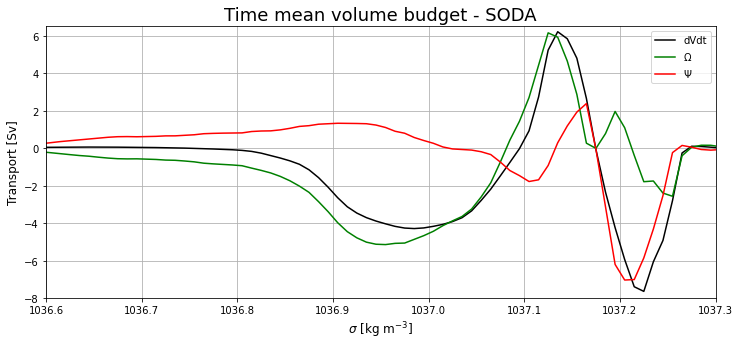

In [8]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k')
wmt_budget_terms.omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
wmt_budget_terms.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
plt.grid()
plt.legend()
plt.xlim(1036.6, 1037.3)
plt.ylim(-8,6.5)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
#plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);
plt.title('Time mean volume budget - SODA', fontsize=18);

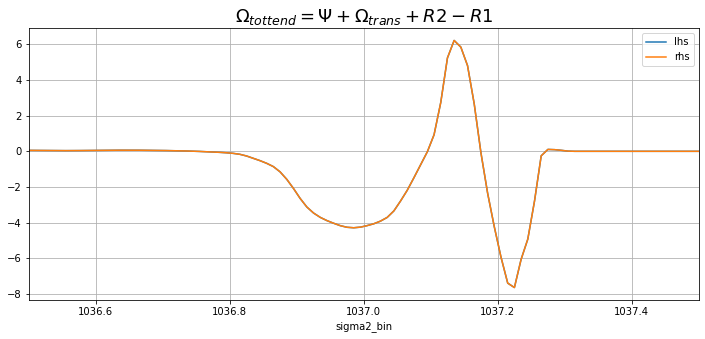

In [5]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='lhs')
(wmt_budget_terms.omega_trans + wmt_budget_terms.psi_vel).mean(dim='time').plot(label='rhs')
plt.grid()
plt.legend()
plt.xlim(1036.5, 1037.5)
plt.title(r'$\Omega_{tottend} = \Psi + \Omega_{trans} + R2 - R1$', fontsize=18, fontweight='bold');

In [17]:
wmt_budget_terms.time.sel(time='2010', method='nearest')

<xarray.DataArray 'time' (time: 36)>
array([cftime.DatetimeJulian(2010, 1, 8, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 1, 18, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 1, 28, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 2, 7, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 2, 17, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 2, 27, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 3, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 3, 19, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 3, 29, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 4, 8, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 4, 18, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 4, 28, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 5, 8, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 5, 18, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 5, 28, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 6, 7, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 6, 17, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 6, 27, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 7, 7, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 7, 17, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 7, 27, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 8, 6, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 8, 16, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 8, 26, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 9, 5, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 9, 15, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 9, 25, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 10, 5, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 10, 15, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 10, 25, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 11, 4, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 11, 14, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 11, 24, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 12, 4, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 12, 14, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 12, 24, 1, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2010-01-08 01:00:00 ... 2010-12-24 01:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [13]:
wmt_budget_terms.dVdt.rolling(time=3).mean(dim='time')

<ipython-input-13-fe7e4ee15bfb>:1: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  wmt_budget_terms.dVdt.rolling(time=3).mean(dim='time')


<xarray.DataArray 'dVdt' (time: 182, sigma2_bin: 699)>
dask.array<truediv, shape=(182, 699), dtype=float64, chunksize=(162, 175), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * time        (time) object 2006-01-09 01:00:00 ... 2010-12-24 01:00:00

In [7]:
wmt_budget_terms.dVdt.groupby('time.month').mean(dim='time')

<xarray.DataArray 'dVdt' (month: 12, sigma2_bin: 699)>
dask.array<stack, shape=(12, 699), dtype=float64, chunksize=(1, 175), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [18]:
def anom(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    anom_chunk = anom.chunk({'time':-1, 'sigma2_bin':-1})
    anom_rolled = anom_chunk.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
    return anom_rolled

In [19]:
anom_ds = xr.merge([wmt_budget_terms.dVdt.rename('dVdt'),
                    wmt_budget_terms.psi_vel.rename('psi_vel'),
                    wmt_budget_terms.omega_trans.rename('omega_trans')])


In [20]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [21]:
clim_ds = anom_ds

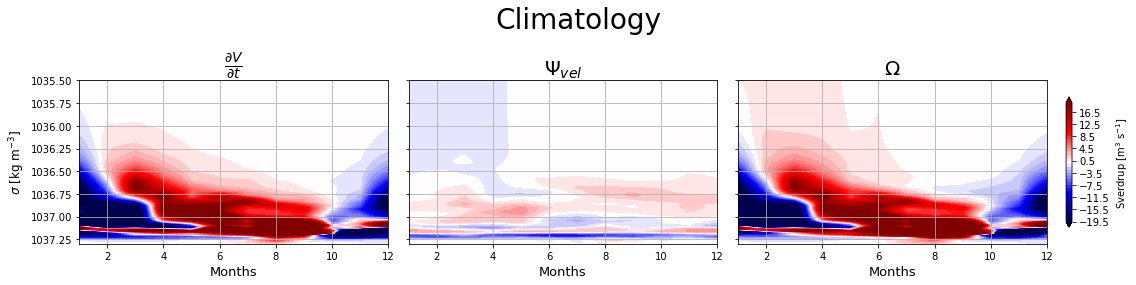

In [24]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-20, 20) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax0.contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_xlabel('Months', fontsize=13)
ax0.set_ylim(1037.3, 1035.5)
#ax[0,0].set_xlim(xmin='1993')
ax0.grid()

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax1.contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_xlabel('Months', fontsize=13)
ax1.set_ylim(1037.3, 1035.5)
#ax[0,1].set_xlim(xmin='1993')
ax1.grid()

omega_clim = clim(clim_ds.omega_trans)
c_omega = ax2.contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_xlabel('Months', fontsize=13)
ax2.set_ylim(1037.3, 1035.5)
#ax[0,2].set_xlim(xmin='1993')
ax2.grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

In [25]:
year_start_index =[0, 36, 73, 109, 146]

In [26]:
wmt_budget_terms.psi_vel.time.values[year_start_index]

array([cftime.DatetimeJulian(2006, 1, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 1, 4, 1, 0, 0, 0),
       cftime.DatetimeJulian(2008, 1, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2009, 1, 3, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 1, 8, 1, 0, 0, 0)], dtype=object)

In [52]:
anom(anom_ds.dVdt)

<ipython-input-51-fcb488d1d76f>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom_chunk.rolling(time=36).mean(dim='time') #monthly rolling mean


<xarray.DataArray 'dVdt' (time: 182, sigma2_bin: 699)>
dask.array<truediv, shape=(182, 699), dtype=float64, chunksize=(164, 699), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * time        (time) object 2006-01-09 01:00:00 ... 2010-12-24 01:00:00
    month       (time) int64 dask.array<chunksize=(182,), meta=np.ndarray>

In [84]:
sam.ANN.isel(index=slice(49, 54))

<xarray.DataArray 'ANN' (index: 5)>
array([ 1.51, -0.77,  2.28,  0.22,  3.28])
Coordinates:
    time     (index) int64 2006 2007 2008 2009 2010
Dimensions without coordinates: index

In [85]:
dVdt_anom_rolled.time.values[year_start_index]

array([cftime.DatetimeJulian(2006, 1, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 1, 4, 1, 0, 0, 0),
       cftime.DatetimeJulian(2008, 1, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2009, 1, 3, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 1, 8, 1, 0, 0, 0)], dtype=object)

<ipython-input-18-3d3384b88b7f>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom_chunk.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
<ipython-input-28-79f94e1a8605>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax0.pcolormesh(dVdt_anom_rolled.time,
<ipython-input-18-3d3384b88b7f>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom_chunk.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
<ipython-input-28-79f94e1a

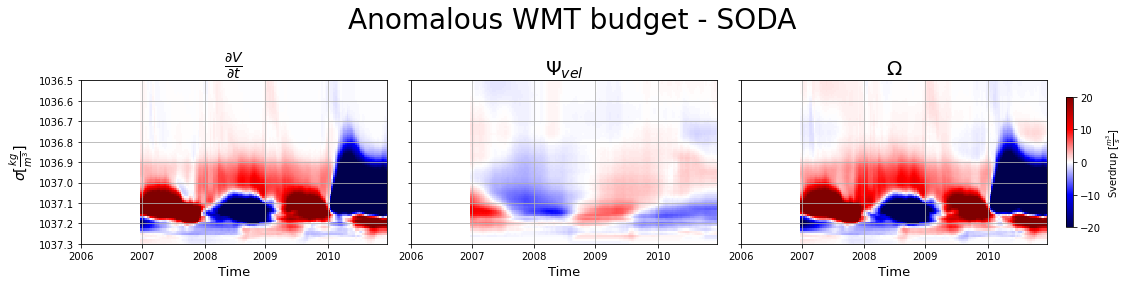

In [28]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})#, sharex=True)

#ax00 = ax0.twinx()
#ax10 = ax1.twinx()
#ax20 = ax2.twinx()

dVdt_anom_rolled = anom(anom_ds.dVdt) / 1e6
c = ax0.pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_ylim(1037.3, 1036.5)
ax0.set_xticks(dVdt_anom_rolled.time.values[year_start_index])
ax0.set_xticklabels(np.arange(2006, 2011))
ax0.set_xlabel('Time', fontsize=13)
#ax00.plot(sam.time.isel(index=slice(49, 54)), sam.ANN.isel(index=slice(49, 54)))
#ax00.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax0.grid()

psi_vel_anom_rolled = anom(anom_ds.psi_vel)
c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_ylim(1037.3, 1036.5)
ax1.set_xticks(psi_vel_anom_rolled.time.values[year_start_index])
ax1.set_xticklabels(np.arange(2006, 2011))
ax1.set_xlabel('Time', fontsize=13)
#ax10.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax1.grid()

omega_anom_rolled = anom(anom_ds.omega_trans)
c_omega = ax2.pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_ylim(1037.3, 1036.5)
ax2.set_xticks(omega_anom_rolled.time.values[year_start_index])
ax2.set_xticklabels(np.arange(2006, 2011))
ax2.set_xlabel('Time', fontsize=13)
#ax20.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax2.grid()

plt.suptitle('Anomalous WMT budget - SODA', fontsize=28)
plt.tight_layout();

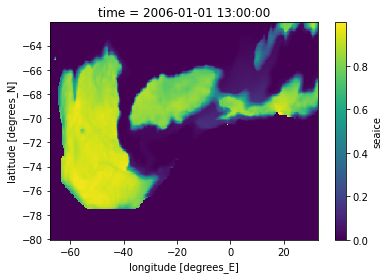

In [33]:
seaice_sose.seaice.sum('ct')[0].plot();

In [37]:
seaice_sose.seaice.sum('ct')

<xarray.DataArray 'seaice' (time: 366, yt: 169, xt: 381)>
dask.array<sum-aggregate, shape=(366, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2006-01-01 13:00:00 ... 2010-12-31 13:00:00
  * xt       (xt) float64 -67.34 -67.1 -66.87 -66.63 ... 31.99 32.24 32.48 32.72
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

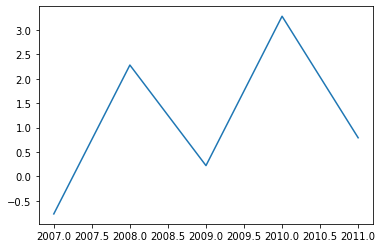

In [89]:
plt.plot(sam.time.isel(index=slice(50, 55)), sam.ANN.isel(index=slice(50, 55)));

In [91]:
sam.ANN.isel(index=slice(50, 55))

<xarray.DataArray 'ANN' (index: 5)>
array([-0.77,  2.28,  0.22,  3.28,  0.79])
Coordinates:
    time     (index) int64 2007 2008 2009 2010 2011
Dimensions without coordinates: index

In [14]:
import pandas as pd

In [45]:
sam = pd.read_csv('newsam.1957.2007.seas.csv', delim_whitespace=True)

In [46]:
sam

,ANN,AUT,WIN,SPR,SUM
1957,-4.24,-2.52,-0.68,-3.55,-2.52
1958,-1.27,-2.97,-0.92,1.42,1.12
1959,0.47,-0.94,-1.22,3.20,0.31
1960,1.52,0.74,0.32,1.00,-0.08
1961,1.22,0.48,0.93,0.85,2.19
...,...,...,...,...,...
2017,1.67,1.34,1.15,1.42,2.33
2018,1.96,-0.81,-0.76,3.92,1.43
2019,-1.50,1.03,-1.30,-2.57,-0.96
2020,1.03,0.55,-1.14,1.26,2.88


In [48]:
sam = sam.to_xarray()

In [50]:
sam.index.rename('time')

<xarray.DataArray 'time' (index: 65)>
array([1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])
Coordinates:
  * index    (index) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020 2021

In [52]:
x = sam.index.rename('time')

In [53]:
x

<xarray.DataArray 'time' (index: 65)>
array([1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])
Coordinates:
  * index    (index) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020 2021

In [67]:
sam = sam.assign_coords(coords={'time':sam.index.rename('time')}).drop('index')

In [92]:
import datetime

In [96]:
sam.time.astype(dVdt_anom_rolled.time.values[year_start_index].dtype)

<xarray.DataArray 'time' (index: 65)>
array([1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype=object)
Coordinates:
    time     (index) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020 2021
Dimensions without coordinates: index

In [94]:
dVdt_anom_rolled.time

<xarray.DataArray 'time' (time: 182)>
array([cftime.DatetimeJulian(2006, 1, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 1, 19, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 1, 29, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 2, 8, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 2, 18, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 2, 28, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 3, 10, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 3, 20, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 3, 30, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 4, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 4, 19, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 4, 29, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 5, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 5, 19, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 5, 29, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 6, 8, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 6, 18, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 6, 28, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 7, 8, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 7, 18, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 7, 28, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 8, 7, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 8, 17, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 8, 27, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 9, 6, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 9, 16, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 9, 26, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 10, 6, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 10, 16, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 10, 26, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 11, 5, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 11, 15, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 11, 25, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 12, 5, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 12, 15, 1, 0, 0, 0),
       cftime.DatetimeJulian(2006, 12, 25, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 1, 4, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 1, 14, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 1, 24, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 2, 3, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 2, 13, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 2, 23, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 3, 5, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 3, 15, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 3, 25, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 4, 4, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 4, 14, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 4, 24, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 5, 4, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 5, 14, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 5, 24, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 6, 3, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 6, 13, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 6, 23, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 7, 3, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 7, 13, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 7, 23, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 8, 2, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 8, 12, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 8, 22, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 9, 1, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 9, 11, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 9, 21, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 10, 1, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 10, 11, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 10, 21, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 10, 31, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 11, 10, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 11, 20, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 11, 30, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 12, 10, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 12, 20, 1, 0, 0, 0),
     

In [93]:
datetime.datetime(sam.time)

TypeError: only size-1 arrays can be converted to Python scalars

In [78]:
sam.time[50]

<xarray.DataArray 'time' ()>
array(2007)
Coordinates:
    time     int64 2007

In [79]:
sam.time[54]

<xarray.DataArray 'time' ()>
array(2011)
Coordinates:
    time     int64 2011

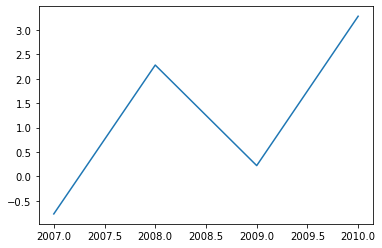

In [80]:
plt.plot(sam.time.isel(index=slice(50, 54)), sam.ANN.isel(index=slice(50, 54)))
plt.;